# Application of Classification Model

#### Problem Statement

This data was extracted from the census bureau database found at: http://www.census.gov/ftp/pub/DES/www/welcome.html

Donor: Ronny Kohavi and Barry Becker, Data Mining and Visualization.

Sillicon Graphics.
e-mail: ronnyk@sgi.com for questions. 
Split into train-test using MLC++GenCVFiles(2/3, 1/3 random).
48842 instances, mix of continuous and discrete (train=32561, test=16281)
45222 if instances with unknown values are removed (train=30162, test=15060)
Duplicate or conflicting instances: 6
Class probabilities for adult.all file
Probability for the label '>50K':23.93%/24.78% (without unknowns)
Probability for the label '<=50K':76.07%/75.22% (without unknowns)

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted
using the following conditions.

((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)) Prediction task is to determine whether a person makes over
50K a year. Conversion of original data as follows:
    1. Discretized as gross income into two ranges with threshold 50,000.
    2. Convert U.S. to US to avoid periods.
    3. Convert Unknown to "?"
    4. Run MLC++GenCVFiles to generate data, test. 
    
 Description of fnlwgt (final weight).
 
 The weights on the CPS files are controlled to independent estimates of the civillian noninstitutional population
 of the US. These are prepared monthly for us by population Division here at the Census Bureau. We use 3 sets of
 controls.
 
 These are:
     1. A single cell estimate of the population 16+ for each state. 
     2. Controls for Hispanic Origin by age and sex.
     3. Controls by Race, age and sex.
 
 We use all three sets of controls in our weighting program and 'rake' through them 6 times so that by the end we come
 back to all the controls we used. 
 
 The term estimate refers to population totals derived from CPS by creating "weighted  tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.
 
Dataset Link
 
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/ 

 
Problem 1:
Prediction task is to determine whether a person makes over 50K a year. 
 
Problem 2:
Which factors are important 

Problem 3:
Which algorithms are best for this dataset 

In [4]:
import pandas as pd
import numpy as np
import math
import statsmodels as sm
import sklearn as skl
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
Train_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, sep=' *, *', engine='python')
Test_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, sep=' *, *', engine='python', header = None)

In [6]:
pd.set_option('display.max_columns', None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status','occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week','native_country', 'wage_class'] 

In [7]:
Train_data.columns = col_labels
Test_data.columns = col_labels

In [8]:
Train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
Test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [11]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


#### Analyze Data

Let’s plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

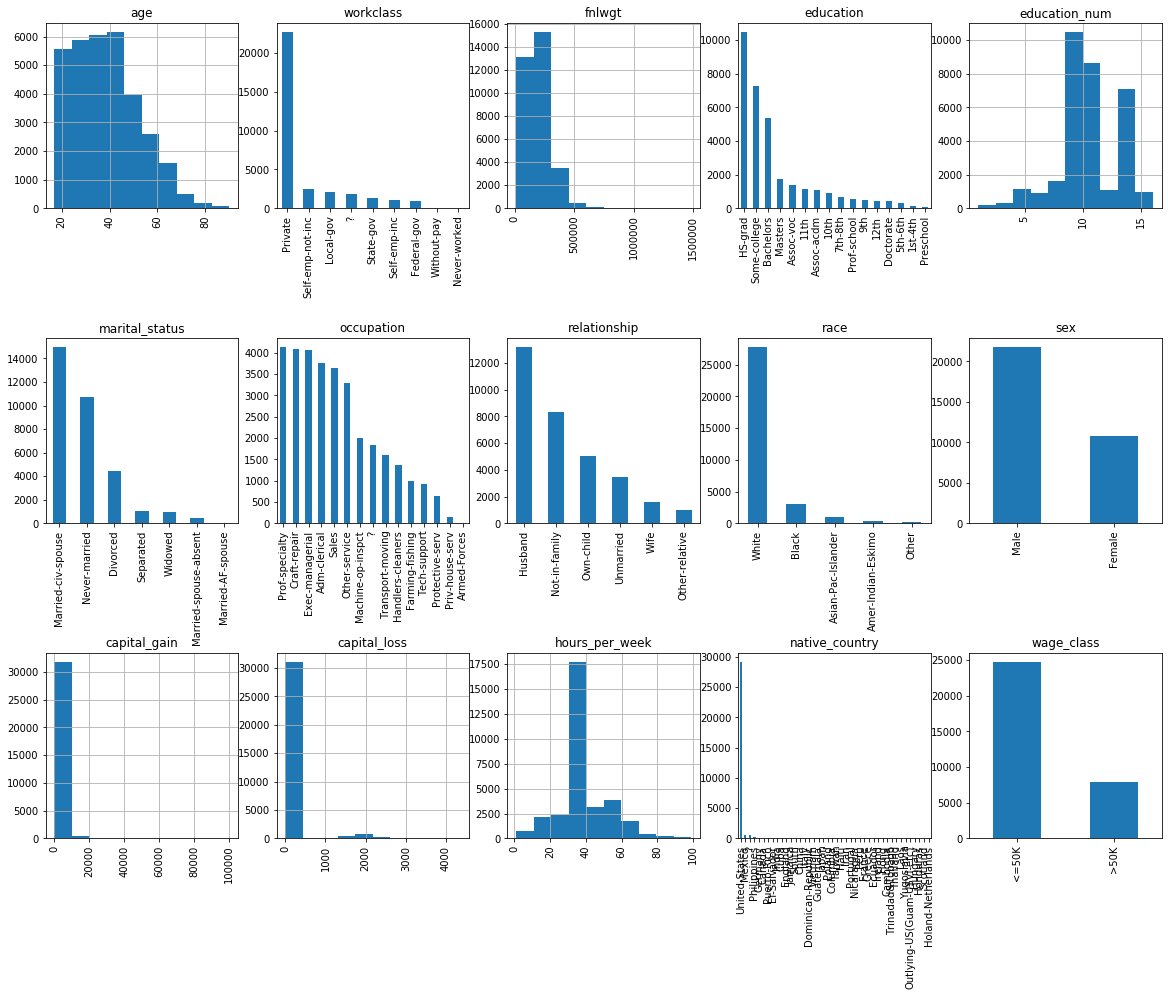

In [12]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = 3
for i, column in enumerate(Train_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if Train_data.dtypes[column] == np.object:
        Train_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        Train_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

We can see from the plots above that our data is mostly concentrated in the USA with mostly male and white colored

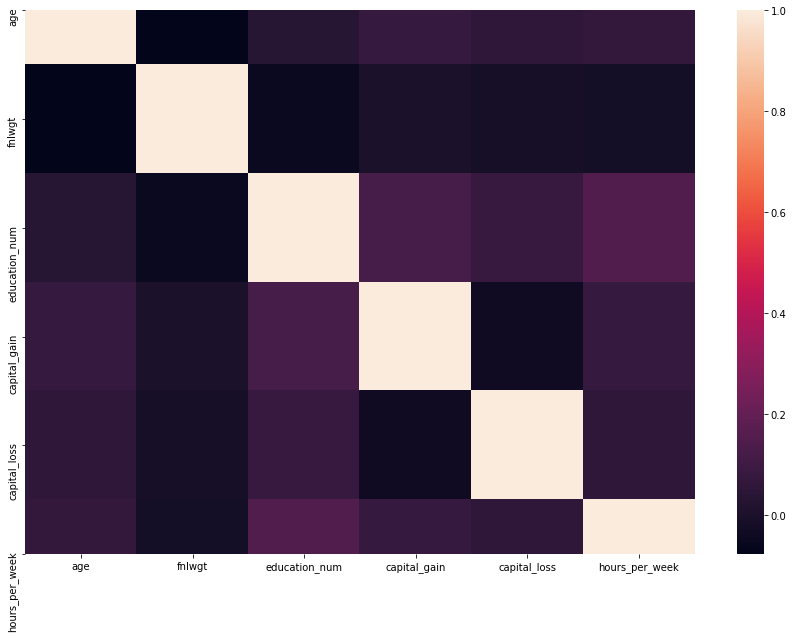

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(Train_data.corr())

#### Handling? value across Training and Test dataset
There are no missing or null values but Replacing all? With string unknown.

In [14]:
Train_data.replace('?', 'Unknown', inplace=True)

In [15]:
Test_data.replace('?', 'Unknown', inplace=True)

#### Feature: Age, Fnlwgt, capital_gain, capital_loss and hours_per_week across Training and Test datast
Age, fnlwgt, capital_gain, capital_loss and hours_per_week is continuous in nature so it is to be discretized

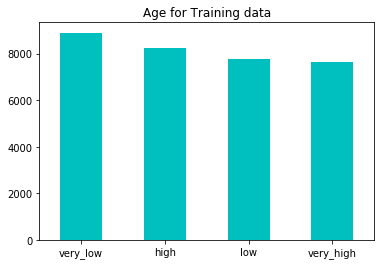

In [16]:
Train_data['Age_Bin'] = pd.qcut(Train_data.age, 4, labels=['very_low','low','high','very_high'])
pd.qcut(Train_data.age, 4, labels=['very_low','low','high','very_high']).value_counts().plot(kind='bar', title='Age for Training data', color='c', rot=0);

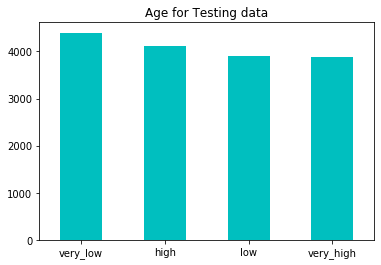

In [17]:
Test_data['Age_Bin'] = pd.qcut(Test_data.age, 4, labels=['very_low','low','high','very_high'])
pd.qcut(Test_data.age, 4, labels=['very_low','low','high','very_high']).value_counts().plot(kind='bar', title='Age for Testing data', color='c', rot=0);

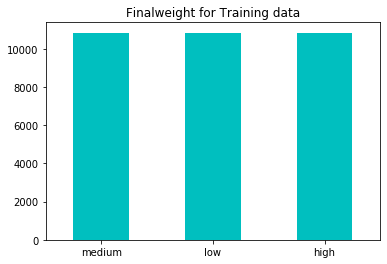

In [18]:
Train_data['Fnlwgt_Bin'] = pd.qcut(Train_data.fnlwgt, 3, labels=['low','medium','high'])
pd.qcut(Train_data.fnlwgt, 3, labels=['low','medium','high']).value_counts().plot(kind='bar', title='Finalweight for Training data', color='c', rot=0);

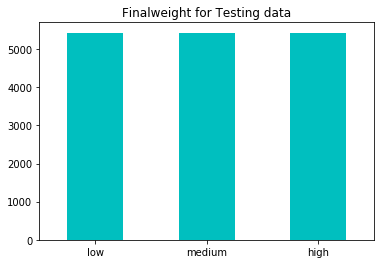

In [19]:
Test_data['Fnlwgt_Bin'] = pd.qcut(Test_data.fnlwgt, 3, labels=['low','medium','high'])
pd.qcut(Test_data.fnlwgt, 3, labels=['low','medium','high']).value_counts().plot(kind='bar', title='Finalweight for Testing data', color='c', rot=0);

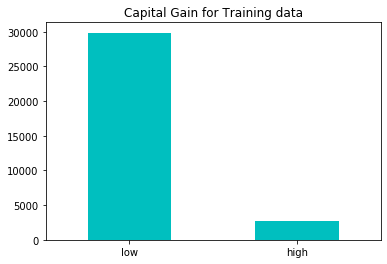

In [20]:
cap_gain = Train_data['capital_gain']
Train_data['Capital_gain_Bin'] = list(map(lambda cap_gain:"low" if(cap_gain==0) else "high", cap_gain))
Train_data.Capital_gain_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Gain for Training data', color='c');

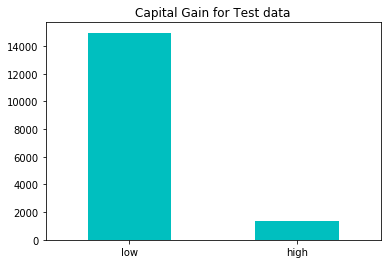

In [21]:
cap_gain = Test_data['capital_gain']
Test_data['Capital_gain_Bin'] = list(map(lambda cap_gain:"low" if(cap_gain==0) else "high", cap_gain))
Test_data.Capital_gain_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Gain for Test data', color='c');

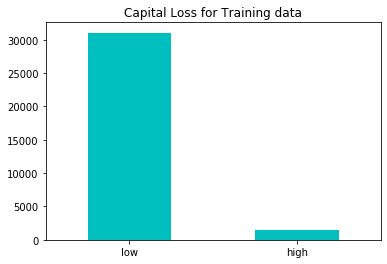

In [22]:
cap_loss = Train_data['capital_loss']
Train_data['Capital_loss_Bin'] = list(map(lambda cap_loss:"low" if(cap_loss==0) else "high", cap_loss))
Train_data.Capital_loss_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Loss for Training data', color='c');

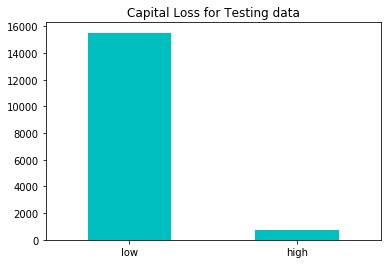

In [23]:
cap_loss = Test_data['capital_loss']
Test_data['Capital_loss_Bin'] = list(map(lambda cap_loss:"low" if(cap_loss==0) else "high", cap_loss))
Test_data.Capital_loss_Bin.value_counts().plot(kind='bar',rot = 0, title='Capital Loss for Testing data', color='c');

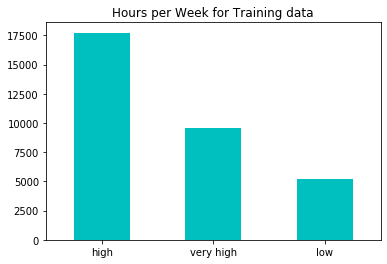

In [24]:
hpw = Train_data['hours_per_week']
Train_data['Hours_per_week_Bin'] = list(map(lambda hpw:"low" if(hpw<=30) else "high" if (hpw>30 and hpw<=40) else "very high", hpw))
Train_data.Hours_per_week_Bin.value_counts().plot(kind='bar',rot = 0, title='Hours per Week for Training data', color='c');

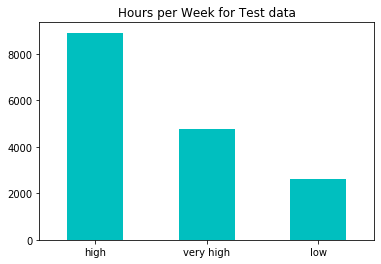

In [25]:
hpw = Test_data['hours_per_week']
Test_data['Hours_per_week_Bin'] = list(map(lambda hpw:"low" if(hpw<=30) else "high" if (hpw>30 and hpw<=40) else "very high", hpw))
Test_data.Hours_per_week_Bin.value_counts().plot(kind='bar',rot = 0, title='Hours per Week for Test data', color='c');

#### One Hot Encoding for Feature Age, fnlwgt, capital_gain, capital_loss and hours_per_week across Training and Test dataset

In [26]:
Train_dummies_age_bin = pd.get_dummies(Train_data.Age_Bin, drop_first=True, prefix='Age')
Train_dummies_fnlwgt_bin = pd.get_dummies(Train_data.Fnlwgt_Bin, drop_first=True, prefix='Fnlwgt')
Train_dummies_capital_gain_bin = pd.get_dummies(Train_data.Capital_gain_Bin, drop_first=True, prefix='Capital_gain')
Train_dummies_capital_loss_bin = pd.get_dummies(Train_data.Capital_loss_Bin, drop_first=True, prefix='Capital_loss')
Train_dummies_hours_per_week_bin = pd.get_dummies(Train_data.Hours_per_week_Bin, drop_first=True, prefix='Hours_per_week')

In [27]:
Train_data = Train_data.join([Train_dummies_age_bin,Train_dummies_fnlwgt_bin,Train_dummies_capital_gain_bin,Train_dummies_capital_loss_bin,Train_dummies_hours_per_week_bin])

In [28]:
Train_data = Train_data.drop(['age','Age_Bin','fnlwgt','Fnlwgt_Bin','capital_gain','Capital_gain_Bin','capital_loss','Capital_loss_Bin','hours_per_week','Hours_per_week_Bin'],axis=1)

In [29]:
Train_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0,1,0,0,0,0,1,0,0
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0,0,1,0,0,1,1,1,0
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K,0,1,0,0,1,1,1,0,0
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K,0,0,1,0,1,1,1,0,0
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K,0,0,0,0,1,1,1,0,0


In [30]:
Test_dummies_age_bin = pd.get_dummies(Test_data.Age_Bin, drop_first=True, prefix='Age')
Test_dummies_fnlwgt_bin = pd.get_dummies(Test_data.Fnlwgt_Bin, drop_first=True, prefix='Fnlwgt')
Test_dummies_capital_gain_bin = pd.get_dummies(Test_data.Capital_gain_Bin, drop_first=True, prefix='Capital_gain')
Test_dummies_capital_loss_bin = pd.get_dummies(Test_data.Capital_loss_Bin, drop_first=True, prefix='Capital_loss')
Test_dummies_hours_per_week_bin = pd.get_dummies(Test_data.Hours_per_week_Bin, drop_first=True, prefix='Hours_per_week')

In [31]:
Test_data = Test_data.join([Test_dummies_age_bin,Test_dummies_fnlwgt_bin,Test_dummies_capital_gain_bin,Test_dummies_capital_loss_bin,Test_dummies_hours_per_week_bin])

In [32]:
Test_data = Test_data.drop(['age','Age_Bin','fnlwgt','Fnlwgt_Bin','capital_gain','Capital_gain_Bin','capital_loss','Capital_loss_Bin','hours_per_week','Hours_per_week_Bin'],axis=1)

In [33]:
Test_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,native_country,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high
0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K.,0,0,0,0,1,1,1,0,0
1,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K.,0,1,0,0,0,1,1,0,1
2,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K.,0,0,0,0,1,1,1,0,0
3,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K.,0,1,0,1,0,0,1,0,0
4,Unknown,Some-college,10,Never-married,Unknown,Own-child,White,Female,United-States,<=50K.,0,0,0,0,0,1,1,1,0


#### Feature: native_country across Training and Test dataset
There are 42 countries in total, so it's better if we transform the feature by bucketing them across continent and drop 
native_country coulmn itself.

In [34]:
categories_dict = {"United-States":"North America","Mexico":"North America","Unknown":"Unknown","Philippines":"Asia","Germany":"Europe","Canada":"North America","Puerto-Rico":"Central America","El-Salvador":"Central America","India":"Asia","Cuba":"Central America","England":"Europe","Jamaica":"Central America","South":"Asia","China":"Asia","Italy":"Europe","Dominican-Republic":"Central America","Vietnam":"Asia","Guatemala":"Central America","Japan":"Asia","Poland":"Europe","Columbia":"South America","Taiwan":"Asia",
"Haiti":"Central America","Iran":"Asia","Portugal":"Europe","Nicaragua":"Central America","Peru":"South America","Greece":"Europe","France":"Europe","Ecuador":"South America","Ireland":"Europe","Hong":"Asia","Cambodia":"Asia","Trinadad&Tobago":"Central America","Laos":"Asia","Thailand":"Asia","Yugoslavia":"Europe","Outlying-US(Guam-USVI-etc)":"North America","Honduras":"Central America","Hungary":"Europe","Scotland":"Europe","Holand-Netherlands":"Europe"}
Train_data['Continent'] = Train_data['native_country'].map(categories_dict)
Test_data['Continent'] = Test_data['native_country'].map(categories_dict)

In [35]:
Train_data = Train_data.drop(['native_country'],axis=1)
Test_data = Test_data.drop(['native_country'],axis=1)

In [36]:
Train_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,<=50K,0,1,0,0,0,0,1,0,0,North America
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,<=50K,0,0,1,0,0,1,1,1,0,North America
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,<=50K,0,1,0,0,1,1,1,0,0,North America
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,<=50K,0,0,1,0,1,1,1,0,0,North America
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,<=50K,0,0,0,0,1,1,1,0,0,Central America


In [37]:
Test_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent
0,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K.,0,0,0,0,1,1,1,0,0,North America
1,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K.,0,1,0,0,0,1,1,0,1,North America
2,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,>50K.,0,0,0,0,1,1,1,0,0,North America
3,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,>50K.,0,1,0,1,0,0,1,0,0,North America
4,Unknown,Some-college,10,Never-married,Unknown,Own-child,White,Female,<=50K.,0,0,0,0,0,1,1,1,0,North America


#### One Hot Encoding for Feature native_country across Training and Test dataset

In [38]:
Train_dummies_native_country = pd.get_dummies(Train_data.Continent, drop_first=True, prefix='Continent')
Test_dummies_native_country = pd.get_dummies(Test_data.Continent, drop_first=True, prefix='Continent')

In [39]:
Train_data = Train_data.join(Train_dummies_native_country)
Test_data = Test_data.join(Test_dummies_native_country)

In [40]:
Train_data = Train_data.drop(['Continent'],axis=1)
Test_data = Test_data.drop(['Continent'],axis=1)

#### Feature : education and education_num both represent the same information across Training and Test dataset

education and education_num leading to multicollinearity. So, let us drop column education_num

In [41]:
Train_data.education.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

In [42]:
Train_data.education_num.value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64

In [43]:
Train_data.drop(['education_num'], axis=1, inplace=True)

In [44]:
Test_data.education.value_counts()

HS-grad         5283
Some-college    3587
Bachelors       2670
Masters          934
Assoc-voc        679
11th             637
Assoc-acdm       534
10th             456
7th-8th          309
Prof-school      258
9th              242
12th             224
Doctorate        181
5th-6th          176
1st-4th           79
Preschool         32
Name: education, dtype: int64

In [45]:
Test_data.education_num.value_counts()

9     5283
10    3587
13    2670
14     934
11     679
7      637
12     534
6      456
4      309
15     258
5      242
8      224
16     181
3      176
2       79
1       32
Name: education_num, dtype: int64

In [46]:
Test_data.drop(['education_num'], axis=1, inplace=True)

In [47]:
Train_data.head()

,workclass,education,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,<=50K,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,<=50K,0,0,1,0,0,1,1,1,0,0,0,1,0,0
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,<=50K,0,1,0,0,1,1,1,0,0,0,0,1,0,0
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,<=50K,0,0,1,0,1,1,1,0,0,0,0,1,0,0
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,<=50K,0,0,0,0,1,1,1,0,0,1,0,0,0,0


In [48]:
Test_data.head()

,workclass,education,marital_status,occupation,relationship,race,sex,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K.,0,0,0,0,1,1,1,0,0,0,0,1,0,0
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K.,0,1,0,0,0,1,1,0,1,0,0,1,0,0
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,>50K.,0,0,0,0,1,1,1,0,0,0,0,1,0,0
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,>50K.,0,1,0,1,0,0,1,0,0,0,0,1,0,0
4,Unknown,Some-college,Never-married,Unknown,Own-child,White,Female,<=50K.,0,0,0,0,0,1,1,1,0,0,0,1,0,0


#### One Hot Encoding for Features: workclass,education,marital_status,occupation,relationship,race,sex across Training and Test dataset

In [49]:
Train_data = pd.get_dummies(Train_data,columns=['workclass','education','marital_status','occupation','relationship','race','sex'],drop_first=True)
Test_data = pd.get_dummies(Test_data,columns=['workclass','education','marital_status','occupation','relationship','race','sex'],drop_first=True)

#### Label(wage_class)Transformation :

In Training dataset the values are <=50K and >50k whereas in Testing dataset the values are <=50K. and >50k. These string values need to be transformed as classfier value as 0 and 1. 0 and 1 states <=50k and >50k respectively


In [50]:
Train_data['wage_class'] = Train_data['wage_class'].map({'<=50K':0,'>50K':1})
Test_data['wage_class'] = Test_data['wage_class'].map({'<=50K.':0,'>50K.':1})

In [51]:
Train_data.head()

,wage_class,Age_low,Age_high,Age_very_high,Fnlwgt_medium,Fnlwgt_high,Capital_gain_low,Capital_loss_low,Hours_per_week_low,Hours_per_week_very high,Continent_Central America,Continent_Europe,Continent_North America,Continent_South America,Continent_Unknown,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [52]:
y_Train = Train_data.iloc[:,0]
X_Train = Train_data.iloc[:,1:]

In [53]:
y_Test = Test_data.iloc[:,0]
X_Test = Test_data.iloc[:,1:]

#### 1. Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!


In [69]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X_Train, y_Train)
predicted = model.predict(X_Test)
# check accuracy score on Test dataset
print("Accuracy is ", metrics.accuracy_score(y_Test, predicted)*100,"%")

Accuracy is  85.0316319636386 %


So, The accuracy score using logistic regression model is 85.03% which is pretty good.

#### 2. Decision Tree Classifier

Let's go ahead and run decision tree on the entire data set, and see how accurate it is!

In [55]:
from sklearn.tree import DecisionTreeClassifier
# train the decision tree
dtree = DecisionTreeClassifier(criterion='gini', random_state=0)
dtree.fit(X_Train, y_Train)
predicted = dtree.predict(X_Test)

In [56]:
conf_mat = metrics.confusion_matrix(y_Test, predicted)
print(conf_mat)
TN = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TP = conf_mat[1][1]
print("True Negative :",TN)
print("False Positive :",FP)
print("False Negative :",FN)
print("True Positive :",TP)

[[11024  1411]
 [ 1837  2009]]
True Negative : 11024
False Positive : 1411
False Negative : 1837
True Positive : 2009


In [57]:
# how did my model perform?
Error = (FP + FN)/(TN+FP+FN+TP)
print('Classification Error: {:.2f}'.format(Error))
Accuracy = (TP + TN)/(TN+FP+FN+TP)
print("Accuracy : {:.2f}".format(Accuracy))
# Out of actual 1, how much is predicted as 1?
Sensitivity = TP/(FN+TP)
print("Sensitivity/Recall/True Positive Rate: {:.2f}".format(Sensitivity))
# Out of actual 0, how much is predicted as 0?
Specifity = TN/(FP+TN)
print("Specifity : {:.2f}".format(Specifity))
# when the actual 0, how much is predicted as 1?
FPR = FP/(TN+FP)
print("False Positive Rate : {:.2f}".format(FPR))
# when the predicted value is 1, how much prediction is correct?
Precision_1 = TP/(FP+TP)
print("Precision for 1: {:.2f}".format(Precision_1))
# when the predicted value is 0, how much prediction is correct?
Precision_0 = TN/(FN+TN)
print("Precision for 0 : {:.2f}".format(Precision_0))

Classification Error: 0.20
Accuracy : 0.80
Sensitivity/Recall/True Positive Rate: 0.52
Specifity : 0.89
False Positive Rate : 0.11
Precision for 1: 0.59
Precision for 0 : 0.86


The F1-score reveals weighted average between precision and recall which means if the value approaches 1, it's infered as a good score.

In [58]:
report = classification_report(y_Test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87     12435
           1       0.59      0.52      0.55      3846

    accuracy                           0.80     16281
   macro avg       0.72      0.70      0.71     16281
weighted avg       0.79      0.80      0.80     16281



So, The accuracy score using decision tree model is 80% which is pretty good.

#### 3. RandomForest Classifier

Let's go ahead and run random forest on the entire data set, and see how accurate it is!

In [68]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

rf = RandomForestClassifier(random_state=1)
rf.fit(X_Train, y_Train)
predicted = rf.predict(X_Test)
print(roc_auc_score(y_Test, predicted))

0.7241153843982469


In [60]:
conf_mat = metrics.confusion_matrix(y_Test, predicted)
print(conf_mat)
TN = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TP = conf_mat[1][1]
print("True Negative :",TN)
print("False Positive :",FP)
print("False Negative :",FN)
print("True Positive :",TP)

[[11261  1174]
 [ 1759  2087]]
True Negative : 11261
False Positive : 1174
False Negative : 1759
True Positive : 2087


In [61]:
# how did my model perform?
Error = (FP + FN)/(TN+FP+FN+TP)
print('Classification Error: {:.2f}'.format(Error))
Accuracy = (TP + TN)/(TN+FP+FN+TP)
print("Accuracy : {:.2f}".format(Accuracy))
# Out of actual 1, how much is predicted as 1?
Sensitivity = TP/(FN+TP)
print("Sensitivity/Recall/True Positive Rate: {:.2f}".format(Sensitivity))
# Out of actual 0, how much is predicted as 0?
Specifity = TN/(FP+TN)
print("Specifity : {:.2f}".format(Specifity))
# when the actual 0, how much is predicted as 1?
FPR = FP/(TN+FP)
print("False Positive Rate : {:.2f}".format(FPR))
# when the predicted value is 1, how much prediction is correct?
Precision_1 = TP/(FP+TP)
print("Precision for 1: {:.2f}".format(Precision_1))
# when the predicted value is 0, how much prediction is correct?
Precision_0 = TN/(FN+TN)
print("Precision for 0 : {:.2f}".format(Precision_0))

Classification Error: 0.18
Accuracy : 0.82
Sensitivity/Recall/True Positive Rate: 0.54
Specifity : 0.91
False Positive Rate : 0.09
Precision for 1: 0.64
Precision for 0 : 0.86


The F1-score reveals weighted average between precision and recall which means if the value approaches 1, it's infered as a good score.

In [62]:
report = classification_report(y_Test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     12435
           1       0.64      0.54      0.59      3846

    accuracy                           0.82     16281
   macro avg       0.75      0.72      0.74     16281
weighted avg       0.81      0.82      0.81     16281



So, The accuracy score using decision tree model is 82% which is pretty good.

#### 4. Bagging Classifier

Let's go ahead and run Bagging on top of KNN on the entire data set, and see how accurate it is!

In [63]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bag_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors=5), n_estimators=20, max_samples=0.5, bootstrap=True, random_state=3) 
bag_knn.fit(X_Train, y_Train)
predicted = bag_knn.predict(X_Test)
print("Accuracy is ", metrics.accuracy_score(y_Test,predicted)*100)

Accuracy is  83.32412014004053


#### 5. K-Nearest Neighbour Classifier

Let's go ahead and run KNN on the entire data set, and see how accurate it is!

In [64]:
from sklearn.neighbors import KNeighborsClassifier
for K in range(25):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(X_Train, y_Train) 
    predicted = neigh.predict(X_Test)
    print("Accuracy is ", metrics.accuracy_score(y_Test,predicted)*100,"% for K-Value:",K_value)

Accuracy is  78.82193968429458 % for K-Value: 1
Accuracy is  81.14366439407898 % for K-Value: 2
Accuracy is  81.46919722375775 % for K-Value: 3
Accuracy is  82.01584669246361 % for K-Value: 4
Accuracy is  82.51950125913642 % for K-Value: 5
Accuracy is  82.45193784165592 % for K-Value: 6
Accuracy is  82.86960260426264 % for K-Value: 7
Accuracy is  82.9617345371906 % for K-Value: 8
Accuracy is  82.97401879491431 % for K-Value: 9
Accuracy is  82.90645537743382 % for K-Value: 10
Accuracy is  83.14599840304649 % for K-Value: 11
Accuracy is  83.13371414532277 % for K-Value: 12
Accuracy is  83.04158221239481 % for K-Value: 13
Accuracy is  83.10300350101345 % for K-Value: 14
Accuracy is  83.31797801117867 % for K-Value: 15
Accuracy is  83.23198820711258 % for K-Value: 16
Accuracy is  83.26884098028377 % for K-Value: 17
Accuracy is  83.48381549044899 % for K-Value: 18
Accuracy is  83.45310484613967 % for K-Value: 19
Accuracy is  83.48995761931086 % for K-Value: 20
Accuracy is  83.58823168110067

So, the optimal value for k=21 gives accuracy of 83.58%

#### 6. Naive Bayes Classifier

Let's go ahead and run Gaussian NB on the entire data set, and see how accurate it is!

In [65]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_Train,y_Train)
predicted = model.predict(X_Test)
print("Accuracy is ", metrics.accuracy_score(y_Test, predicted)*100,"%")

Accuracy is  58.23352373932805 %


So, The accuracy score using Naive Bayes model is 58.23% which is poor.

#### 7. XG Boost Classifier
Let's go ahead and run XGB on the entire data set, and see how accurate it is!

In [67]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

data_dmatrix = xgb.DMatrix(data=X_Train,label=y_Train)
xg_class = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
xg_class.fit(X_Train,y_Train)
predicted = xg_class.predict(X_Test)
accuracy = metrics.accuracy_score(y_Test, predicted)
print("Accuracy is %.2f%%" % (accuracy * 100.0))

Accuracy is 85.07%


So, the accuracy score using XGB Classifier is 85.04% which is pretty good and seems to outperform other classifiers.

#### Inference : XG Boost Classifier is found to be the best for the dataset.